In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from scipy import sparse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv("diabetic_data.csv")
ids_mapping = pd.read_csv("IDS_mapping.csv")

Preprocessing

In [3]:
# Predict whether or not hospital patient will be readmitted within 30 days

# Replace "?" with NaN to standardize missing values
df = df.replace("?", np.nan)

# Target variable includes those recently readmitted (within 30 days)
# creates a binary target where 1 = readmitted <30, 0 otherise
if "readmitted" in df.columns:
    df["target"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)
    df = df.drop(["readmitted"], axis=1)
    
# Drop ID and unhelpful columns
drop_cols = ["encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty", "examide",  "citoglipton", "metformin-rosiglitazone", "metformin-pioglitazone"]
df = df.drop(columns=drop_cols, errors='ignore')

# Drop columns with excessive missing values or high cardinality
df = df.loc[:, df.isnull().mean() < 0.5]
df = df.drop(columns=[col for col in df.select_dtypes(include="object") if df[col].nunique() > 50])
df = df.dropna()

# One-hot encode with float dtype to avoid object dtype issues
df_dummies = pd.get_dummies(df, drop_first=True, dtype=float)

# Separate features and target
X = df_dummies.drop("target", axis=1)
y = df_dummies["target"]

# Convert to scipy sparse matrix
X_sparse = sparse.csr_matrix(X.values)

# Train/test split (sparse matrix version)
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.3, random_state=42, stratify=y
)


# Feature scaling using sparse-compatible scaler (no centering)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_sparse)
X_test_scaled = scaler.transform(X_test_sparse)

# Prepare to store metrics for later model evaluation
metrics = {}

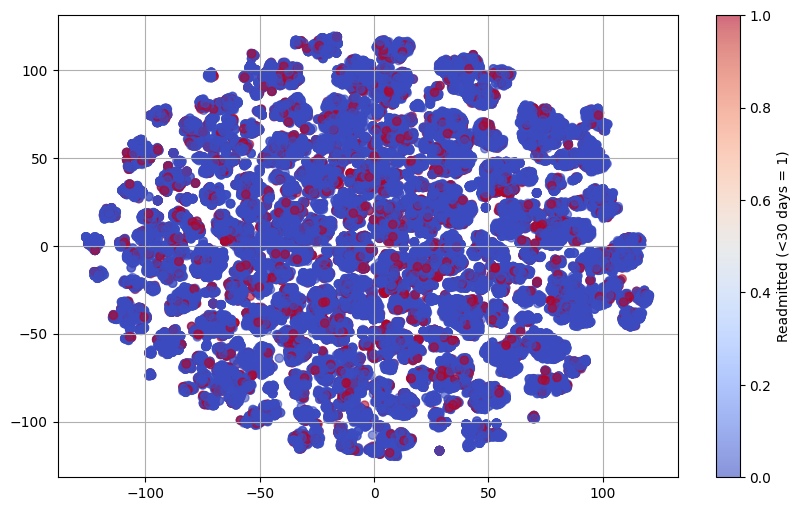

In [4]:
'''
    decided to use t-sne because it allows us to turn this multi dimensional space into a 2d space
    therefore, we can see what model is the best to use, as a guess  
    then we can compare THIS inital guess to the FINAL result
'''
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_embedded = tsne.fit_transform(X_train_scaled.toarray())

# Plot
plt.figure(figsize=(10, 6))
# 0 (NOT readmitted) = blue || 1 (readmitted) = red
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap="coolwarm", alpha=0.6)
plt.colorbar(scatter, label="Readmitted (<30 days = 1)")
plt.grid(True)
plt.show()

k-Nearest Neighors

In [ ]:
'''
# Convert sparse matrices to dense arrays (KNN doesn't support sparse input)
X_train_dense = X_train_scaled.toarray()
X_test_dense = X_test_scaled.toarray()

metrics["kNN"] = {}

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_dense, y_train)
    
    y_pred_knn = knn.predict(X_test_dense)
    
    metrics["kNN"][k] = {
        "Accuracy": accuracy_score(y_test, y_pred_knn),
        "Precision": precision_score(y_test, y_pred_knn, zero_division=0),
        "Recall": recall_score(y_test, y_pred_knn),
        "F1": f1_score(y_test, y_pred_knn),
        "AUC": roc_auc_score(y_test, y_pred_knn)
    }

    print(f"\nk = {k}")
    for metric_name, value in metrics["kNN"][k].items():
        print(f"{metric_name}: {value:.4f}")

# Extract metric values for each k
ks = list(metrics["kNN"].keys())
accuracy = [metrics["kNN"][k]["Accuracy"] for k in ks]
precision = [metrics["kNN"][k]["Precision"] for k in ks]
recall = [metrics["kNN"][k]["Recall"] for k in ks]
f1 = [metrics["kNN"][k]["F1"] for k in ks]
auc = [metrics["kNN"][k]["AUC"] for k in ks]

plt.figure(figsize=(10, 6))

plt.plot(ks, accuracy, label="Accuracy", marker='o')
plt.plot(ks, precision, label="Precision", marker='o')
plt.plot(ks, recall, label="Recall", marker='o')
plt.plot(ks, f1, label="F1 Score", marker='o')
plt.plot(ks, auc, label="AUC", marker='o')

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Score")
plt.title("KNN Classifier Metrics vs k")
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()


# Convert sparse matrices to dense arrays (KNN doesn't support sparse input)
X_train_dense = X_train_scaled.toarray()
X_test_dense = X_test_scaled.toarray()

# Initialize metrics dictionary
metrics = {"kNN": {}}

# Train and evaluate KNN with k=1
k = 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_dense, y_train)
y_pred_knn = knn.predict(X_test_dense)

# Store metrics
metrics["kNN"][k] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn, zero_division=0),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1": f1_score(y_test, y_pred_knn),
    "AUC": roc_auc_score(y_test, y_pred_knn)
}

# Print metrics
print(f"\nk = {k}")
for metric_name, value in metrics["kNN"][k].items():
    print(f"{metric_name}: {value:.4f}")

# Plot metrics for k=1
metric_names = list(metrics["kNN"][k].keys())
metric_values = list(metrics["kNN"][k].values())

plt.figure(figsize=(8, 5))
plt.bar(metric_names, metric_values, color='skyblue')
plt.title("KNN (k=1) Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

'''

# Convert sparse matrices to dense arrays (kNN doesn't support sparse input)
X_train_dense = X_train_scaled.toarray()
X_test_dense = X_test_scaled.toarray()

# Define parameter grid
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],  # optional
    'metric': ['euclidean']  # you can add 'manhattan', etc.
}

# Set up GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search_knn.fit(X_train_dense, y_train)

# Best model
best_knn = grid_search_knn.best_estimator_

# Predict on test set
y_pred_knn = best_knn.predict(X_test_dense)

# Store metrics
metrics["kNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn, zero_division=0),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1": f1_score(y_test, y_pred_knn),
    "AUC": roc_auc_score(y_test, best_knn.predict_proba(X_test_dense)[:, 1])
}

# Print metrics
print(f"\nBest k: {best_knn.n_neighbors}")
for metric_name, value in metrics["kNN"].items():
    print(f"{metric_name}: {value:.4f}")


Logistic Regression

In [ ]:
# Define parameter grid for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # 'lbfgs' only supports l2
    'class_weight': ['balanced'],
    'max_iter': [1000],
    'random_state': [42]
}

# Initialize base model
base_model = LogisticRegression()

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Retrieve best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred_lr = best_model.predict(X_test_scaled)

# Evaluate and store metrics
metrics["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "AUC": roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
}

# Print metrics
for metric_name, value in metrics["Logistic Regression"].items():
    print(f"{metric_name}: {value:.4f}")

# Print best hyperparameters
print("Best hyperparameters found:", grid_search.best_params_)


Feedforward Neural Network

In [ ]:
# Define parameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization term
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000],
    'random_state': [42]
}

# Initialize GridSearchCV
grid_search_mlp = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit the model
grid_search_mlp.fit(X_train_scaled, y_train)

# Best model
best_mlp = grid_search_mlp.best_estimator_

# Predict on test data
y_pred_mlp = best_mlp.predict(X_test_scaled)

# Store metrics
metrics["Feedforward NN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_mlp),
    "Precision": precision_score(y_test, y_pred_mlp),
    "Recall": recall_score(y_test, y_pred_mlp),
    "F1": f1_score(y_test, y_pred_mlp),
    "AUC": roc_auc_score(y_test, best_mlp.predict_proba(X_test_scaled)[:, 1])
}

# Print results
print(f"\nBest Params (MLP): {grid_search_mlp.best_params_}")
for metric_name, value in metrics["Feedforward NN"].items():
    print(f"{metric_name}: {value:.4f}")

Decision Tree

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': list(range(1, 60))
}

# Initialize the base model
dt = DecisionTreeClassifier(random_state=42)

# Setup GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit the grid search on the training data
grid_search_dt.fit(X_train_scaled, y_train)

# Retrieve the best model
best_dt = grid_search_dt.best_estimator_

# Predict on test set
y_pred_dt = best_dt.predict(X_test_scaled)

# Evaluate and store metrics
metrics["Decision Tree"] = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt, zero_division=0),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "AUC": roc_auc_score(y_test, best_dt.predict_proba(X_test_scaled)[:, 1])
}

# Print best max_depth and metrics
print(f"Best max_depth: {grid_search_dt.best_params_['max_depth']}")
for metric_name, value in metrics["Decision Tree"].items():
    print(f"{metric_name}: {value:.4f}")

Confusion Matrices

In [ ]:
def plot_confusion(ax, title, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each confusion matrix
plot_confusion(axes[0, 0], "kNN Confusion Matrix", y_test, y_pred_knn)
plot_confusion(axes[0, 1], "Logistic Regression Confusion Matrix", y_test, y_pred_lr)
plot_confusion(axes[1, 0], "Feedforward NN Confusion Matrix", y_test, y_pred_mlp)
plot_confusion(axes[1, 1], "Decision Tree Confusion Matrix", y_test, y_pred_dt)

# Layout adjustment
plt.tight_layout()
plt.show()

In [ ]:
learning curves

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

def plot_learning_curve(estimator, X, y, ax, title):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    ax.set_title(title)
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
    ax.grid(True)

# Assume X_train and y_train are your training data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_learning_curve(knn_clf, X_train, y_train, axes[0, 0], 'k-NN Learning Curve')
plot_learning_curve(lr_clf, X_train, y_train, axes[0, 1], 'Logistic Regression Learning Curve')
plot_learning_curve(mlp_clf, X_train, y_train, axes[1, 0], 'Feedforward NN Learning Curve')
plot_learning_curve(dt_clf, X_train, y_train, axes[1, 1], 'Decision Tree Learning Curve')

plt.tight_layout()
plt.show()

Visualization of Metrics

In [ ]:
def plot_metrics(metrics_dict):
    metrics_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
    classifiers = list(metrics_dict.keys())
    values = {metric: [metrics_dict[classifier][metric] for classifier in classifiers] for metric in metrics_names}

    x = np.arange(len(classifiers))
    width = 0.2

    plt.figure(figsize=(10,6))
    for i, metric in enumerate(metrics_names):
        plt.bar(x + i*width, values[metric], width=width, label=metric)

    plt.xticks(x + width*1.5, classifiers)
    plt.ylabel("Score")
    plt.title("Metrics by Classifier")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(metrics)

In [ ]:
# for the additional

errors_knn = np.where(y_pred_knn != y_test)[0]
errors_mlp = np.where(y_pred_mlp != y_test)[0]
errors_common = np.intersect1d(errors_knn, errors_mlp)

print(f"Total k-NN errors: {len(errors_knn)}")
print(f"Total MLP errors: {len(errors_mlp)}")
print(f"Overlapping errors: {len(errors_common)}")
print(f"Percentage of k-NN errors shared with MLP: {len(errors_common) / len(errors_knn) * 100:.2f}%")
